In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
#from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import TomekLinks
import matplotlib.pyplot as plt
import seaborn as sns

# Import datasets

In [2]:
csv_path = os.path.join("..", "..", "data","LINKED_DATA", "TSR_ALL", "TSR_ALL1", "TSR_ALL1_MICE2.csv")
tsr_all1_df = pd.read_csv(csv_path)
tsr_all1_df.shape

(44367, 233)

# Convert the multiple feature and outcome into binary ones

In [3]:
mRS1 = tsr_all1_df.mrs_tx_1
mRS1[(mRS1 == 0) | (mRS1 == 1) | (mRS1 == 2)] = 1 #GOOD
mRS1[(mRS1 == 3) | (mRS1 == 4) | (mRS1 == 5) | (mRS1 == 6) | (mRS1 == 9)] = 0 #BAD
# discharged = tsr_all1_df.discharged_mrs
# discharged[(discharged == 0) | (discharged == 1) | (discharged == 2)] = 1 #GOOD
# discharged[(discharged == 3) | (discharged == 4) | (discharged == 5) | (discharged == 6) | (discharged == 9)] = 0 #BAD

<ipython-input-3-ba86dd1f2e79>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mRS1[(mRS1 == 0) | (mRS1 == 1) | (mRS1 == 2)] = 1 #GOOD
<ipython-input-3-ba86dd1f2e79>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mRS1[(mRS1 == 3) | (mRS1 == 4) | (mRS1 == 5) | (mRS1 == 6) | (mRS1 == 9)] = 0 #BAD


# Group all features and the outcome

In [4]:
nominal_features = ["edu_id", "pro_id", "opc_id", "toast_id", "offdt_id", "gender_tx", "hd_id", "pcva_id",
                    "pcvaci_id", "pcvach_id", "po_id", "ur_id", "sm_id", "ptia_id", "hc_id", "hcht_id",
                    "hchc_id", "ht_id", "dm_id", "pad_id", "al_id", "ca_id", "fahiid_parents_1",
                    "fahiid_parents_2", "fahiid_parents_3", "fahiid_parents_4", "fahiid_brsi_1",
                    "fahiid_brsi_2", "fahiid_brsi_3", "fahiid_brsi_4"]
ordinal_features = ["gcse_nm", "gcsv_nm", "gcsm_nm", "discharged_mrs", "feeding", "transfers",
                    "bathing", "toilet_use", "grooming", "mobility", "stairs", "dressing", "bowel_control",
                    "bladder_control", "nihs_1a_in", "nihs_1b_in", "nihs_1c_in", "nihs_2_in", "nihs_3_in", "nihs_4_in",
                    "nihs_5al_in", "nihs_5br_in", "nihs_6al_in", "nihs_6br_in", "nihs_7_in", "nihs_8_in", "nihs_9_in",
                    "nihs_10_in", "nihs_11_in", "nihs_1a_out", "nihs_1b_out", "nihs_1c_out", "nihs_2_out", "nihs_3_out",
                    "nihs_4_out", "nihs_5al_out", "nihs_5br_out", "nihs_6al_out", "nihs_6br_out", "nihs_7_out",
                    "nihs_8_out", "nihs_9_out", "nihs_10_out", "nihs_11_out"]
boolean = ["toastle_fl", "toastli_fl", "toastsce_fl", "toastsmo_fl", "toastsra_fl", "toastsdi_fl",
           "toastsmi_fl", "toastsantip_fl", "toastsau_fl", "toastshy_fl", "toastspr_fl", "toastsantit_fl",
           "toastsho_fl", "toastshys_fl", "toastsca_fl", "thda_fl", "thdh_fl", "thdi_fl", "thdam_fl", "thdv_fl",
           "thde_fl", "thdm_fl", "thdr_fl", "thdp_fl", "trman_fl", "trmas_fl", "trmti_fl", "trmhe_fl",
           "trmwa_fl", "trmia_fl", "trmfo_fl", "trmta_fl", "trmsd_fl", "trmre_fl", "trmen_fl", "trmag_fl",
           "trmcl_fl", "trmpl_fl", "trmlm_fl", "trmiv_fl", "trmve_fl", "trmng_fl", "trmdy_fl", "trmicu_fl",
           "trmsm_fl", "trmed_fl", "trmop_fl", "om_fl", "omas_fl", "omag_fl", "omti_fl", "omcl_fl", "omwa_fl",
           "ompl_fl", "omanh_fl", "omand_fl", "omli_fl", "am_fl", "amas_fl", "amag_fl", "amti_fl", "amcl_fl",
           "amwa_fl", "ampl_fl", "amanh_fl", "amand_fl", "amli_fl", "compn_fl", "comut_fl", "comug_fl",
           "compr_fl", "compu_fl", "comac_fl", "comse_fl", "comde_fl", "detst_fl", "dethe_fl", "detho_fl",
           "detha_fl", "detva_fl", "detre_fl", "detme_fl", "ct_fl", "mri_fl", "ecgl_fl", "ecga_fl", "ecgq_fl",
           "cortical_aca_ctr", "cortical_mca_ctr", "subcortical_aca_ctr", "subcortical_mca_ctr", "pca_cortex_ctr",
           "thalamus_ctr", "brainstem_ctr", "cerebellum_ctr", "watershed_ctr", "hemorrhagic_infarct_ctr",
           "old_stroke_ctci", "cortical_aca_ctl", "cortical_mca_ctl", "subcortical_aca_ctl", "subcortical_mca_ctl",
           "pca_cortex_ctl", "thalamus_ctl", "brainstem_ctl", "cerebellum_ctl", "watershed_ctl",
           "hemorrhagic_infarct_ctl", "old_stroke_ctch", "cortical_aca_mrir", "cortical_mca_mrir",
           "subcortical_aca_mrir", "subcortical_mca_mrir", "pca_cortex_mrir", "thalamus_mrir", "brainstem_mrir",
           "cerebellum_mrir", "watershed_mrir", "hemorrhagic_infarct_mrir", "old_stroke_mrici", "cortical_aca_mril",
           "cortical_mca_mril", "subcortical_aca_mril", "subcortical_mca_mril", "pca_cortex_mril",
           "thalamus_mril", "brainstem_mril", "cerebellum_mril", "watershed_mril", "hemorrhagic_infarct_mril",
           "old_stroke_mrich"]
continuous = ["height_nm", "weight_nm", "sbp_nm", "dbp_nm", "bt_nm", "hr_nm", "rr_nm", "hb_nm",
              "hct_nm", "platelet_nm", "wbc_nm", "ptt1_nm", "ptt2_nm", "ptinr_nm", "er_nm", "bun_nm",
              "cre_nm", "ua_nm", "tcho_nm", "tg_nm", "hdl_nm",
              "ldl_nm", "gpt_nm", "age", "hospitalised_time"]
labels = ["mrs_tx_1"]

# Machine Learning

## Preprocess input data (GOOD when Discharge)

In [5]:
## discharged mRS = GOOD (tsr_all1_df.discharged_mrs == 1)
mrs_dis1 = tsr_all1_df[(tsr_all1_df.discharged_mrs == 1) | (tsr_all1_df.discharged_mrs == 0) | (tsr_all1_df.discharged_mrs == 2)]

In [6]:
## input dataset
tsr_1G_input = mrs_dis1.drop(["icase_id", "idcase_id", "mrs_tx_1"], axis=1)
print(tsr_1G_input.shape)
tsr_1G_input = tsr_1G_input.astype("float64")
tsr_1G_input = np.array(tsr_1G_input.values)

(20658, 230)


In [7]:
## output dataset
tsr_1G_output = mrs_dis1.mrs_tx_1
print(tsr_1G_output.shape)
tsr_1G_output = tsr_1G_output.astype("float64")
tsr_1G_output = np.array(tsr_1G_output.values)

(20658,)


In [8]:
## train_test_split
G_X_train, G_X_test, G_y_train, G_y_test = train_test_split(tsr_1G_input, tsr_1G_output, test_size=0.3, random_state=19)
print("The shape of GOOD's X_train:", G_X_train.shape)
print("The shape of GOOD's y_train:", G_y_train.shape)
print("The shape of GOOD's X_test:", G_X_test.shape)
print("The shape of GOOD's y_test:", G_y_test.shape)

The shape of GOOD's X_train: (14460, 230)
The shape of GOOD's y_train: (14460,)
The shape of GOOD's X_test: (6198, 230)
The shape of GOOD's y_test: (6198,)


In [9]:
## scale G_X_train
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
G_X_train = pd.DataFrame(G_X_train)
G_X_train.columns = tsr_all1_df.drop(["icase_id", "idcase_id", "mrs_tx_1"], axis=1).columns

scaler = MinMaxScaler()
G_X_train[continuous] = scaler.fit_transform(G_X_train[continuous])

encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=6)
G_X_train[ordinal_features] = encoder.fit_transform(G_X_train[ordinal_features])

ohe = OneHotEncoder(sparse=False, handle_unknown = "ignore")
nominal_train = ohe.fit_transform(G_X_train[nominal_features])
G_X_train = pd.concat([G_X_train, pd.DataFrame(nominal_train)], axis=1)
G_X_train = G_X_train.drop(nominal_features, axis=1)

G_x_train_columns = list(G_X_train.columns)
G_x_train_columns = G_x_train_columns[0:200]
get_feature_name = list(ohe.get_feature_names(nominal_features))
G_x_train_columns = G_x_train_columns+get_feature_name

G_X_train = np.array(G_X_train.values)

In [10]:
## scale G_X_test
G_X_test = pd.DataFrame(G_X_test)
G_X_test.columns = tsr_all1_df.drop(["icase_id", "idcase_id", "mrs_tx_1"], axis=1).columns

G_X_test[continuous] = scaler.transform(G_X_test[continuous])

G_X_test[ordinal_features] = encoder.transform(G_X_test[ordinal_features])

nominal_test = ohe.transform(G_X_test[nominal_features])
G_X_test = pd.concat([G_X_test, pd.DataFrame(nominal_test)], axis=1)
G_X_test = G_X_test.drop(nominal_features, axis=1)

G_X_test = np.array(G_X_test.values)

## Algorithms

## Extra trees

In [11]:
# base et
et = ExtraTreesClassifier(random_state=19)

#tune et
hyperparameters_et = {"extratreesclassifier__n_estimators": (25, 100),
                      "extratreesclassifier__criterion": ("gini", "entropy"),
                      "extratreesclassifier__max_depth": (25, 100),
                      "extratreesclassifier__min_samples_split": (25, 100),
                      "extratreesclassifier__max_features": (0.1, 0.9),
                      "extratreesclassifier__bootstrap": (True, False),
                      "extratreesclassifier__class_weight": ('balanced', {0: 1, 1: 25}, {0: 25, 1: 1}),
                      "extratreesclassifier__max_samples": (0.3, 0.8)}

pipeline = make_pipeline(TomekLinks(), ExtraTreesClassifier(random_state=19))

etG_rscv = RandomizedSearchCV(estimator=pipeline,
                              param_distributions=hyperparameters_et,
                              n_jobs=-1,
                              scoring='roc_auc',
                              verbose=5,                        
                              cv=5,
                              n_iter = 50,
                              random_state = 19)

### BASE ET

In [12]:
et.fit(G_X_train, G_y_train)

G_y_train_pred = et.predict_proba(G_X_train)
fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
G_train_auroc = auc(fpr, tpr)
print('AUC of training set:', G_train_auroc)

G_y_test_pred = et.predict_proba(G_X_test)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc)

AUC of training set: 1.0
AUC of testing set: 0.7240499408415451


### TUNE ET

In [13]:
etG_rsCV = etG_rscv.fit(G_X_train, G_y_train)
print('--> Tuned Parameters Best Score: ', etG_rsCV.best_score_)
print('--> Best Parameters: \n', etG_rsCV.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
--> Tuned Parameters Best Score:  0.7346400948626979
--> Best Parameters: 
 {'extratreesclassifier__n_estimators': 100, 'extratreesclassifier__min_samples_split': 25, 'extratreesclassifier__max_samples': 0.8, 'extratreesclassifier__max_features': 0.1, 'extratreesclassifier__max_depth': 25, 'extratreesclassifier__criterion': 'entropy', 'extratreesclassifier__class_weight': {0: 25, 1: 1}, 'extratreesclassifier__bootstrap': True}


In [14]:
G_y_train_pred = etG_rsCV.predict_proba(G_X_train)
fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
G_train_auroc_tuned = auc(fpr, tpr)
print('AUC of training set:', G_train_auroc_tuned)

G_y_test_pred = etG_rsCV.predict_proba(G_X_test)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_tuned = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc_tuned)

AUC of training set: 0.999881024987063
AUC of testing set: 0.7461593989330122


In [15]:
etG_cccv = CalibratedClassifierCV(base_estimator=etG_rsCV.best_estimator_, cv=5)
etG_ccCV = etG_cccv.fit(G_X_train, G_y_train)

G_y_train_pred = etG_ccCV.predict_proba(G_X_train)
fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
G_train_auroc_cc = auc(fpr, tpr)
print('AUC of training set:', G_train_auroc_cc)

G_y_test_pred = etG_ccCV.predict_proba(G_X_test)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_cc = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc_cc)

AUC of training set: 0.9998917508897549
AUC of testing set: 0.7423083330129807


## Thresholds

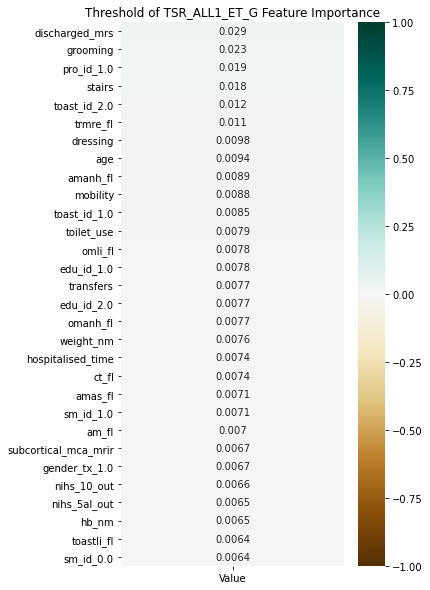

In [16]:
etG_sigma = etG_rsCV.best_estimator_._final_estimator.feature_importances_
etG_sigma_df = pd.DataFrame(etG_sigma)
etG_sigma_df.index = G_x_train_columns
etG_sigma_df.columns = (["Value"])
etG_sigma_plot = etG_sigma_df.sort_values(["Value"], ascending=False).head(30)
etG_sigma_plot.index = (["Discharged mRS", "BI_grooming", "Profession_1", "BI_stairs", "Ischemic subtype_2", 
                         "Inhospitalised treatment-rehab", "BI_dressing", "Age", "Anti H/T drug before admitted", 
                         "BI_mobility", "Ischemic subtype_1", "BI_toilet_use", "Lipid lowering drug after discharged",
                         "Education_1", "BI_transfers", "Education_2", "Anti H/T drug after discharged", "Weight", 
                         "Inhospitalised duration", "CT no finding", "Aspirin before admitted", "Smoking_1", 
                         "No medicines before admitted", "MRI_subcortical MCA_right", "Gender_1", "Discharged NIHSS_10",
                         "Discharged NIHSS_5al", "Hemoglobin", "Large artery atherosclerosis-intra", "Smoking_0"])

plt.figure(figsize=(5, 10))
sns.heatmap(etG_sigma_plot, vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.title('Threshold of TSR_ALL1_ET_G Feature Importance')
plt.savefig('INFO/TSR_ALL1/etG1_sigma_df.png')
plt.show()

### Selected Columns

In [17]:
etG_sigma_df = etG_sigma_df.reset_index(drop=False)
etG_sigma_df.columns = (["Feature","Value"])
etG_sigma_df = etG_sigma_df.sort_values(["Value"], ascending=False)

G_train_auroc_list = []
G_test_auroc_list = []
G_train_auroc_tuned_list = []
G_test_auroc_tuned_list = []
G_train_auroc_cc_list = []
G_test_auroc_cc_list = []

for i in 10,20,30:
    etG_sigma_index = etG_sigma_df[0:i].index
    
    G_X_train = pd.DataFrame(G_X_train)
    G_X_train_selected = G_X_train.iloc[:, etG_sigma_index]
    G_X_train_selected = np.array(G_X_train_selected.values)
    
    G_X_test = pd.DataFrame(G_X_test)
    G_X_test_selected = G_X_test.iloc[:, etG_sigma_index]
    G_X_test_selected = np.array(G_X_test_selected.values)
    
    # base et_selected
    et.fit(G_X_train_selected, G_y_train)
    
    G_y_train_pred = et.predict_proba(G_X_train_selected)
    fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
    G_train_auroc_selected = auc(fpr, tpr)
    G_train_auroc_list.append(G_train_auroc_selected)
    
    G_y_test_pred = et.predict_proba(G_X_test_selected)
    fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
    G_test_auroc_selected = auc(fpr, tpr)
    G_test_auroc_list.append(G_test_auroc_selected)
    
    # tune et_selected
    etG_rsCV_selected = etG_rscv.fit(G_X_train_selected, G_y_train)
    print('--> Tuned Parameters Best Score: ', etG_rsCV_selected.best_score_)
    print('--> Best Parameters: \n', etG_rsCV_selected.best_params_)
    
    G_y_train_pred = etG_rsCV_selected.predict_proba(G_X_train_selected)
    fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
    G_train_auroc_selected_tuned = auc(fpr, tpr)
    G_train_auroc_tuned_list.append(G_train_auroc_selected_tuned)

    G_y_test_pred = etG_rsCV_selected.predict_proba(G_X_test_selected)
    fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
    G_test_auroc_selected_tuned = auc(fpr, tpr)
    G_test_auroc_tuned_list.append(G_test_auroc_selected_tuned)

    etG_cccv = CalibratedClassifierCV(base_estimator=etG_rsCV_selected.best_estimator_, cv=5)
    etG_ccCV = etG_cccv.fit(G_X_train_selected, G_y_train)

    G_y_train_pred = etG_ccCV.predict_proba(G_X_train_selected)
    fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
    G_train_auroc_selected_cc = auc(fpr, tpr)
    G_train_auroc_cc_list.append(G_train_auroc_selected_cc)

    G_y_test_pred = etG_ccCV.predict_proba(G_X_test_selected)
    fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
    G_test_auroc_selected_cc = auc(fpr, tpr)
    G_test_auroc_cc_list.append(G_test_auroc_selected_cc)
    
G_train_auroc_list.append(G_train_auroc)
G_test_auroc_list.append(G_test_auroc)
G_train_auroc_tuned_list.append(G_train_auroc_tuned)
G_test_auroc_tuned_list.append(G_test_auroc_tuned)
G_train_auroc_cc_list.append(G_train_auroc_cc)
G_test_auroc_cc_list.append(G_test_auroc_cc)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
--> Tuned Parameters Best Score:  0.7229420720743065
--> Best Parameters: 
 {'extratreesclassifier__n_estimators': 100, 'extratreesclassifier__min_samples_split': 100, 'extratreesclassifier__max_samples': 0.3, 'extratreesclassifier__max_features': 0.1, 'extratreesclassifier__max_depth': 100, 'extratreesclassifier__criterion': 'gini', 'extratreesclassifier__class_weight': {0: 25, 1: 1}, 'extratreesclassifier__bootstrap': True}
Fitting 5 folds for each of 50 candidates, totalling 250 fits
--> Tuned Parameters Best Score:  0.7274437131333722
--> Best Parameters: 
 {'extratreesclassifier__n_estimators': 100, 'extratreesclassifier__min_samples_split': 100, 'extratreesclassifier__max_samples': 0.8, 'extratreesclassifier__max_features': 0.1, 'extratreesclassifier__max_depth': 100, 'extratreesclassifier__criterion': 'gini', 'extratreesclassifier__class_weight': {0: 1, 1: 25}, 'extratreesclassifier__bootstrap': False}
Fitting 5 folds

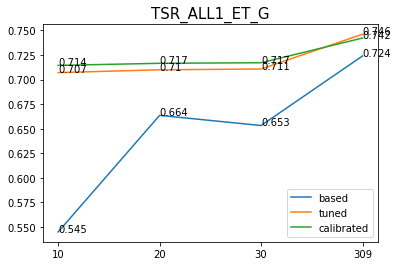

In [18]:
x = "10","20","30","309"
#plt.plot(x, G_train_auroc_list, label = "training")
plt.plot(x, G_test_auroc_list, label = "based")
#plt.plot(x, G_train_auroc_tuned_list, label = "training")
plt.plot(x, G_test_auroc_tuned_list, label = "tuned")
#plt.plot(x, G_train_auroc_cc_list, label = "training")
plt.plot(x, G_test_auroc_cc_list, label = "calibrated")
plt.legend()
for i in range(len(x)):
    plt.annotate(round(G_test_auroc_list[i],3), (x[i], G_test_auroc_list[i]))
    plt.annotate(round(G_test_auroc_tuned_list[i],3), (x[i], G_test_auroc_tuned_list[i]))
    plt.annotate(round(G_test_auroc_cc_list[i],3), (x[i], G_test_auroc_cc_list[i]))
plt.title('TSR_ALL1_ET_G', fontsize=15)
plt.savefig('INFO/TSR_ALL1/TSR_ALL1_ET_G.png')
plt.show()

## XGBClassifier

In [19]:
# base xgbc
xgbc = XGBClassifier(random_state=19, use_label_encoder=False, eval_metric = "auc", tree_method = "hist", n_jobs=-1)

# tune xgbc
hyperparameters_xgbc = {"xgbclassifier__booster": ("gbtree", "dart"),
                        "xgbclassifier__learning_rate": (0.01, 0.1),
                        "xgbclassifier__max_depth": (25, 50),
                        "xgbclassifier__subsample": (0.3, 0.8),
                        "xgbclassifier__colsample_bytree": (0.3, 0.8),
                        "xgbclassifier__reg_lambda": (0.1, 10),
                        "xgbclassifier__reg_alpha": (0.1, 10),
                        "xgbclassifier__gamma": (0.1, 10),
                        "xgbclassifier__n_estimators": (25, 100),
                        "xgbclassifier__scale_pos_weight": (0.05, 25)}

pipeline = make_pipeline(TomekLinks(), XGBClassifier(random_state=19, use_label_encoder=False, eval_metric="auc", tree_method = "hist"))

xgbcG_rscv = RandomizedSearchCV(estimator=pipeline,                       
                                param_distributions=hyperparameters_xgbc,                      
                                n_jobs=-1,                      
                                scoring="roc_auc",                     
                                verbose=5,                      
                                cv=5,                        
                                n_iter=50,
                                random_state = 19)

### BASE XGBC

In [20]:
xgbc.fit(G_X_train, G_y_train)

G_y_train_pred = xgbc.predict_proba(G_X_train)
fpr, tpr, thresholds = roc_curve(G_y_train , G_y_train_pred[:, 1])
G_train_auroc = auc(fpr, tpr)
print('AUC of training set:', G_train_auroc)

G_y_test_pred = xgbc.predict_proba(G_X_test)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc)

AUC of training set: 1.0
AUC of testing set: 0.679926703315009


C:\Users\Jacky C\anaconda3\envs\tsr_ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Jacky C\anaconda3\envs\tsr_ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


### TUNE XGBC

In [21]:
xgbcG_rsCV = xgbcG_rscv.fit(G_X_train, G_y_train)
print("--> Tuned Parameters Best Score: ", xgbcG_rsCV.best_score_)
print("--> Best Parameters: \n", xgbcG_rsCV.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
--> Tuned Parameters Best Score:  0.7376662239368449
--> Best Parameters: 
 {'xgbclassifier__subsample': 0.3, 'xgbclassifier__scale_pos_weight': 25, 'xgbclassifier__reg_lambda': 0.1, 'xgbclassifier__reg_alpha': 10, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__max_depth': 50, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__gamma': 0.1, 'xgbclassifier__colsample_bytree': 0.3, 'xgbclassifier__booster': 'gbtree'}


In [22]:
G_y_train_pred = xgbcG_rsCV.predict_proba(G_X_train)
fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
G_train_auroc_tuned = auc(fpr, tpr)
print('AUC of training set:', G_train_auroc_tuned)

G_y_test_pred = xgbcG_rsCV.predict_proba(G_X_test)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_tuned = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc_tuned)

AUC of training set: 0.8480387934448563
AUC of testing set: 0.7375551540469083


C:\Users\Jacky C\anaconda3\envs\tsr_ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Jacky C\anaconda3\envs\tsr_ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [23]:
xgbcG_cccv = CalibratedClassifierCV(base_estimator=xgbcG_rsCV.best_estimator_, cv=5)
xgbcG_ccCV = xgbcG_cccv.fit(G_X_train, G_y_train)

G_y_train_pred = xgbcG_ccCV.predict_proba(G_X_train)
fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
G_train_auroc_cc = auc(fpr, tpr)
print('AUC of training set:', G_train_auroc_cc)

G_y_test_pred = xgbcG_ccCV.predict_proba(G_X_test)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_cc = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc_cc)

C:\Users\Jacky C\anaconda3\envs\tsr_ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Jacky C\anaconda3\envs\tsr_ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


AUC of training set: 0.8493773861008143
AUC of testing set: 0.7540597222756142


## Thresholds

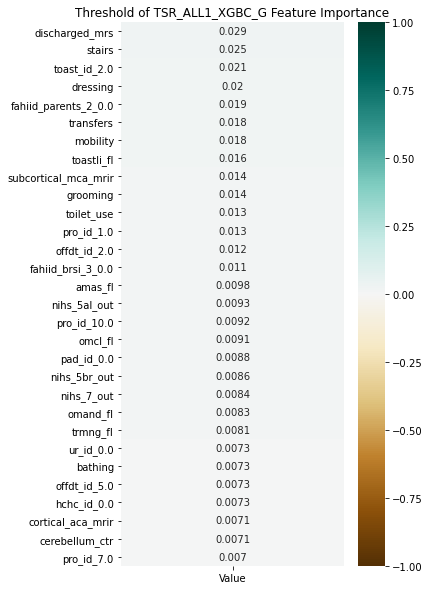

In [24]:
xgbcG_sigma = xgbcG_rsCV.best_estimator_._final_estimator.feature_importances_
xgbcG_sigma_df = pd.DataFrame(xgbcG_sigma)
xgbcG_sigma_df.index = G_x_train_columns
xgbcG_sigma_df.columns = (["Value"])
xgbcG_sigma_plot = xgbcG_sigma_df.sort_values(["Value"], ascending=False).head(30)
xgbcG_sigma_plot.index = (["Discharged mRS", "BI_stairs", "Ischemic subtype_2", "BI_dressing", 
                           "Parents having diabetes mellitus_0", "BI_transfers", "BI_mobility", 
                           "Large artery atherosclerosis-intra", "MRI_subcortical MCA_right", "BI_grooming", 
                           "BI_toilet_use", "Profession_1", "Destination after discharged_2", 
                           "Siblings having ischemic stroke_0", "Aspirin before admitted", "Discharged NIHSS_5al",
                           "Profession_10", "Clopidogrel after discharged", "Peripheral arterial disease_0", 
                           "Discharged NIHSS_5br", "Discharged NIHSS_7", "Anti DM drug after discharged", 
                           "Inhospitalised treatment-nasogastric tube", "Uremia_0", "BI_bathing", 
                           "Destination after discharged_5", "Hypercholesterolemia_0", "MRI_cortical ACA_right", 
                           "CT_cerebellum_right", "Profession_7"])

plt.figure(figsize=(5, 10))
sns.heatmap(xgbcG_sigma_plot, vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.title('Threshold of TSR_ALL1_XGBC_G Feature Importance')
plt.savefig('INFO/TSR_ALL1/xgbcG1_sigma_df.png')
plt.show()

### Selected Columns

In [25]:
xgbcG_sigma_df = xgbcG_sigma_df.reset_index(drop=False)
xgbcG_sigma_df.columns = (["Feature","Value"])
xgbcG_sigma_df = xgbcG_sigma_df.sort_values(["Value"], ascending=False)

G_train_auroc_list = []
G_test_auroc_list = []
G_train_auroc_tuned_list = []
G_test_auroc_tuned_list = []
G_train_auroc_cc_list = []
G_test_auroc_cc_list = []

for i in 10,20,30:
    xgbcG_sigma_index = xgbcG_sigma_df[0:i].index
    
    G_X_train = pd.DataFrame(G_X_train)
    G_X_train_selected = G_X_train.iloc[:, xgbcG_sigma_index]
    G_X_train_selected = np.array(G_X_train_selected.values)
    
    G_X_test = pd.DataFrame(G_X_test)
    G_X_test_selected = G_X_test.iloc[:, xgbcG_sigma_index]
    G_X_test_selected = np.array(G_X_test_selected.values)
    
    et = ExtraTreesClassifier(random_state=19)
    et.fit(G_X_train_selected, G_y_train)
    
    G_y_train_pred = et.predict_proba(G_X_train_selected)
    fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
    G_train_auroc_selected = auc(fpr, tpr)
    G_train_auroc_list.append(G_train_auroc_selected)
    
    G_y_test_pred = et.predict_proba(G_X_test_selected)
    fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
    G_test_auroc_selected = auc(fpr, tpr)
    G_test_auroc_list.append(G_test_auroc_selected)
    
    xgbcG_rsCV_selected = xgbcG_rscv.fit(G_X_train_selected, G_y_train)
    print('--> Tuned Paramxgbcers Best Score: ', xgbcG_rsCV_selected.best_score_)
    print('--> Best Paramxgbcers: \n', xgbcG_rsCV_selected.best_params_)

    G_y_train_pred = xgbcG_rsCV_selected.predict_proba(G_X_train_selected)
    fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
    G_train_auroc_selected_tuned = auc(fpr, tpr)
    G_train_auroc_tuned_list.append(G_train_auroc_selected_tuned)

    G_y_test_pred = xgbcG_rsCV_selected.predict_proba(G_X_test_selected)
    fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
    G_test_auroc_selected_tuned = auc(fpr, tpr)
    G_test_auroc_tuned_list.append(G_test_auroc_selected_tuned)

    xgbcG_cccv = CalibratedClassifierCV(base_estimator=xgbcG_rsCV_selected.best_estimator_, cv=5)
    xgbcG_ccCV = xgbcG_cccv.fit(G_X_train_selected, G_y_train)

    G_y_train_pred = xgbcG_ccCV.predict_proba(G_X_train_selected)
    fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
    G_train_auroc_selected_cc = auc(fpr, tpr)
    G_train_auroc_cc_list.append(G_train_auroc_selected_cc)

    G_y_test_pred = xgbcG_ccCV.predict_proba(G_X_test_selected)
    fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
    G_test_auroc_selected_cc = auc(fpr, tpr)
    G_test_auroc_cc_list.append(G_test_auroc_selected_cc)
    
G_train_auroc_list.append(G_train_auroc)
G_test_auroc_list.append(G_test_auroc)
G_train_auroc_tuned_list.append(G_train_auroc_tuned)
G_test_auroc_tuned_list.append(G_test_auroc_tuned)
G_train_auroc_cc_list.append(G_train_auroc_cc)
G_test_auroc_cc_list.append(G_test_auroc_cc)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
--> Tuned Paramxgbcers Best Score:  0.7100811117132858
--> Best Paramxgbcers: 
 {'xgbclassifier__subsample': 0.8, 'xgbclassifier__scale_pos_weight': 0.05, 'xgbclassifier__reg_lambda': 10, 'xgbclassifier__reg_alpha': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__max_depth': 50, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__gamma': 0.1, 'xgbclassifier__colsample_bytree': 0.3, 'xgbclassifier__booster': 'dart'}


C:\Users\Jacky C\anaconda3\envs\tsr_ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Jacky C\anaconda3\envs\tsr_ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Jacky C\anaconda3\envs\tsr_ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Jacky C\anaconda3\envs\tsr_ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Fitting 5 folds for each of 50 candidates, totalling 250 fits
--> Tuned Paramxgbcers Best Score:  0.7323028444428906
--> Best Paramxgbcers: 
 {'xgbclassifier__subsample': 0.3, 'xgbclassifier__scale_pos_weight': 0.05, 'xgbclassifier__reg_lambda': 0.1, 'xgbclassifier__reg_alpha': 0.1, 'xgbclassifier__n_estimators': 25, 'xgbclassifier__max_depth': 25, 'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__gamma': 0.1, 'xgbclassifier__colsample_bytree': 0.3, 'xgbclassifier__booster': 'dart'}


C:\Users\Jacky C\anaconda3\envs\tsr_ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Jacky C\anaconda3\envs\tsr_ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Jacky C\anaconda3\envs\tsr_ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Jacky C\anaconda3\envs\tsr_ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Fitting 5 folds for each of 50 candidates, totalling 250 fits
--> Tuned Paramxgbcers Best Score:  0.7332825376149595
--> Best Paramxgbcers: 
 {'xgbclassifier__subsample': 0.8, 'xgbclassifier__scale_pos_weight': 0.05, 'xgbclassifier__reg_lambda': 10, 'xgbclassifier__reg_alpha': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__max_depth': 50, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__gamma': 0.1, 'xgbclassifier__colsample_bytree': 0.3, 'xgbclassifier__booster': 'dart'}


C:\Users\Jacky C\anaconda3\envs\tsr_ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Jacky C\anaconda3\envs\tsr_ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Jacky C\anaconda3\envs\tsr_ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Jacky C\anaconda3\envs\tsr_ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


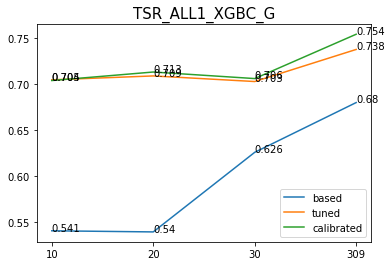

In [26]:
x = "10","20","30","309"
#plt.plot(x, G_train_auroc_list, label = "training")
plt.plot(x, G_test_auroc_list, label = "based")
#plt.plot(x, G_train_auroc_tuned_list, label = "training")
plt.plot(x, G_test_auroc_tuned_list, label = "tuned")
#plt.plot(x, G_train_auroc_cc_list, label = "training")
plt.plot(x, G_test_auroc_cc_list, label = "calibrated")
plt.legend()
for i in range(len(x)):
    plt.annotate(round(G_test_auroc_list[i],3), (x[i], G_test_auroc_list[i]))
    plt.annotate(round(G_test_auroc_tuned_list[i],3), (x[i], G_test_auroc_tuned_list[i]))
    plt.annotate(round(G_test_auroc_cc_list[i],3), (x[i], G_test_auroc_cc_list[i]))
plt.title('TSR_ALL1_XGBC_G', fontsize=15)
plt.savefig('INFO/TSR_ALL1/TSR_ALL1_XGBC_G.png')
plt.show()

# Machine Learning

## Preprocess input data (BAD when Discharge)

In [27]:
# discharged mRS = BAD (tsr_all1_df.discharged_mrs == 0)
mrs_dis0 = tsr_all1_df[(tsr_all1_df.discharged_mrs != 1) & (tsr_all1_df.discharged_mrs != 0) & (tsr_all1_df.discharged_mrs != 2)]

In [28]:
## input dataset
tsr_1B_input = mrs_dis0.drop(["icase_id", "idcase_id", "mrs_tx_1"], axis=1)
print(tsr_1B_input.shape)
tsr_1B_input = tsr_1B_input.astype("float64")
tsr_1B_input = np.array(tsr_1B_input.values)

(23709, 230)


In [29]:
## output dataset
tsr_1B_output = mrs_dis0.mrs_tx_1
print(tsr_1B_output.shape)
tsr_1B_output = tsr_1B_output.astype("float64")
tsr_1B_output = np.array(tsr_1B_output.values)

(23709,)


In [30]:
## train_test_split
B_X_train, B_X_test, B_y_train, B_y_test = train_test_split(tsr_1B_input, tsr_1B_output, test_size=0.3, random_state=19)
print("The shape of X_train:", B_X_train.shape)
print("The shape of y_train:", B_y_train.shape)
print("The shape of X_test:", B_X_test.shape)
print("The shape of y_test:", B_y_test.shape)

The shape of X_train: (16596, 230)
The shape of y_train: (16596,)
The shape of X_test: (7113, 230)
The shape of y_test: (7113,)


In [31]:
## scale B_X_train
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

B_X_train = pd.DataFrame(B_X_train)
B_X_train.columns = tsr_all1_df.drop(["icase_id", "idcase_id", "mrs_tx_1"], axis=1).columns

scaler = MinMaxScaler()
B_X_train[continuous] = scaler.fit_transform(B_X_train[continuous])

encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=9)
B_X_train[ordinal_features] = encoder.fit_transform(B_X_train[ordinal_features])

ohe = OneHotEncoder(sparse=False)
nominal_train = ohe.fit_transform(B_X_train[nominal_features])
B_X_train = pd.concat([B_X_train, pd.DataFrame(nominal_train)], axis=1)
B_X_train = B_X_train.drop(nominal_features, axis=1)

B_x_train_columns = list(B_X_train.columns)
B_x_train_columns = B_x_train_columns[0:200]
get_feature_name = list(ohe.get_feature_names(nominal_features))
B_x_train_columns = B_x_train_columns+get_feature_name

B_X_train = np.array(B_X_train.values)

In [32]:
## scale B_X_test
B_X_test = pd.DataFrame(B_X_test)
B_X_test.columns = tsr_all1_df.drop(["icase_id", "idcase_id", "mrs_tx_1"], axis=1).columns

B_X_test[continuous] = scaler.transform(B_X_test[continuous])

B_X_test[ordinal_features] = encoder.transform(B_X_test[ordinal_features])

nominal_test = ohe.transform(B_X_test[nominal_features])
B_X_test = pd.concat([B_X_test, pd.DataFrame(nominal_test)], axis=1)
B_X_test = B_X_test.drop(nominal_features, axis=1)

B_X_test = np.array(B_X_test.values)

## Algorithms

## Extra trees

In [33]:
# base et
et = ExtraTreesClassifier(random_state=19)

#tune et
hyperparameters_et = {"extratreesclassifier__n_estimators": (25, 100),
                      "extratreesclassifier__criterion": ("gini", "entropy"),
                      "extratreesclassifier__max_depth": (25, 100),
                      "extratreesclassifier__min_samples_split": (25, 100),
                      "extratreesclassifier__max_features": (0.1, 0.9),
                      "extratreesclassifier__bootstrap": (True, False),
                      "extratreesclassifier__class_weight": ('balanced', {0: 1, 1: 4}, {0: 4, 1: 1}),
                      "extratreesclassifier__max_samples": (0.3, 0.8)}

pipeline = make_pipeline(TomekLinks(), ExtraTreesClassifier(random_state=19))

etB_rscv = RandomizedSearchCV(estimator=pipeline,
                              param_distributions=hyperparameters_et,
                              n_jobs=-1,
                              scoring='roc_auc',
                              verbose=5,                        
                              cv=5,
                              n_iter = 50,
                              random_state = 19)

### BASE ET

In [34]:
et.fit(B_X_train, B_y_train)

B_y_train_pred = et.predict_proba(B_X_train)
fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
B_train_auroc = auc(fpr, tpr)
print('AUC of training set:', B_train_auroc)

B_y_test_pred = et.predict_proba(B_X_test)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc)

AUC of training set: 1.0
AUC of testing set: 0.8479572842704038


### TUNE ET

In [35]:
etB_rsCV = etB_rscv.fit(B_X_train, B_y_train)
print('--> Tuned Parameters Best Score: ', etB_rsCV.best_score_)
print('--> Best Parameters: \n', etB_rsCV.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
--> Tuned Parameters Best Score:  0.8603141587468501
--> Best Parameters: 
 {'extratreesclassifier__n_estimators': 100, 'extratreesclassifier__min_samples_split': 25, 'extratreesclassifier__max_samples': 0.8, 'extratreesclassifier__max_features': 0.1, 'extratreesclassifier__max_depth': 100, 'extratreesclassifier__criterion': 'entropy', 'extratreesclassifier__class_weight': {0: 1, 1: 4}, 'extratreesclassifier__bootstrap': False}


In [36]:
B_y_train_pred = etB_rsCV.predict_proba(B_X_train)
fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
B_train_auroc_tuned = auc(fpr, tpr)
print('AUC of training set:', B_train_auroc_tuned)

B_y_test_pred = etB_rsCV.predict_proba(B_X_test)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_tuned = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc_tuned)

AUC of training set: 0.9981052361934691
AUC of testing set: 0.858048199505693


In [37]:
etB_cccv = CalibratedClassifierCV(base_estimator=etB_rsCV.best_estimator_, cv=5)
etB_ccCV = etB_cccv.fit(B_X_train, B_y_train)

B_y_train_pred = etB_ccCV.predict_proba(B_X_train)
fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
B_train_auroc_cc = auc(fpr, tpr)
print('AUC of training set:', B_train_auroc_cc)

B_y_test_pred = etB_ccCV.predict_proba(B_X_test)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_cc = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc_cc)

AUC of training set: 0.9960164946080675
AUC of testing set: 0.8578611446514918


## Thresholds

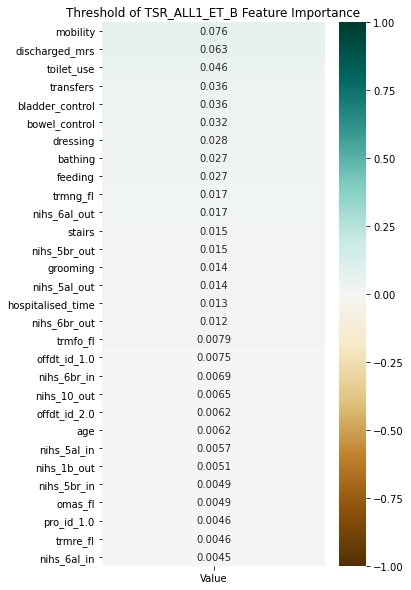

In [38]:
etB_sigma = etB_rsCV.best_estimator_._final_estimator.feature_importances_
etB_sigma_df = pd.DataFrame(etB_sigma)
etB_sigma_df.index = B_x_train_columns
etB_sigma_df.columns = (["Value"])
etB_sigma_plot = etB_sigma_df.sort_values(["Value"], ascending=False).head(30)
etB_sigma_plot.index = (["BI_mobility", "Discharged mRS", "BI_toilet_use", "BI_transfers", "BI_bladder_control", 
                         "BI_bowel_control", "BI_dressing", "BI_bathing", "BI_feeding", 
                         "Inhospitalised treatment-nasogastric tube", "Discharged NIHSS_6al", "BI_stairs", 
                         "Discharged NIHSS_5br", "BI_grooming", "Discharged NIHSS_5al", "Inhospitalised duration", 
                         "Discharged NIHSS_6br", "Inhospitalised treatment-foley", "Destination after discharged_1",
                         "Admitted NIHSS_6br", "Discharged NIHSS_10", "Destination after discharged_2", "Age", 
                         "Admitted NIHSS_5al", "Discharged NIHSS_1b", "Admitted NIHSS_5br", "Aspirin after discharged",
                         "Profession_1", "Inhospitalised treatment-rehab", "Admitted NIHSS_6al"])

plt.figure(figsize=(5, 10))
sns.heatmap(etB_sigma_plot, vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.title('Threshold of TSR_ALL1_ET_B Feature Importance')
plt.savefig('INFO/TSR_ALL1/etB1_sigma_df.png')
plt.show()

### Selected Columns

In [39]:
etB_sigma_df = etB_sigma_df.reset_index(drop=False)
etB_sigma_df.columns = (["Feature","Value"])
etB_sigma_df = etB_sigma_df.sort_values(["Value"], ascending=False)

B_train_auroc_list = []
B_test_auroc_list = []
B_train_auroc_tuned_list = []
B_test_auroc_tuned_list = []
B_train_auroc_cc_list = []
B_test_auroc_cc_list = []

for i in 10,20,30:
    etB_sigma_index = etB_sigma_df[0:i].index
    
    B_X_train = pd.DataFrame(B_X_train)
    B_X_train_selected = B_X_train.iloc[:, etB_sigma_index]
    B_X_train_selected = np.array(B_X_train_selected.values)
    
    B_X_test = pd.DataFrame(B_X_test)
    B_X_test_selected = B_X_test.iloc[:, etB_sigma_index]
    B_X_test_selected = np.array(B_X_test_selected.values)
    
    # base et_selected
    et.fit(B_X_train_selected, B_y_train)
    
    B_y_train_pred = et.predict_proba(B_X_train_selected)
    fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
    B_train_auroc_selected = auc(fpr, tpr)
    B_train_auroc_list.append(B_train_auroc_selected)
    
    B_y_test_pred = et.predict_proba(B_X_test_selected)
    fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
    B_test_auroc_selected = auc(fpr, tpr)
    B_test_auroc_list.append(B_test_auroc_selected)
    
    # tune et_selected
    etB_rsCV_selected = etB_rscv.fit(B_X_train_selected, B_y_train)
    print('--> Tuned Parameters Best Score: ', etB_rsCV_selected.best_score_)
    print('--> Best Parameters: \n', etB_rsCV_selected.best_params_)
    
    B_y_train_pred = etB_rsCV_selected.predict_proba(B_X_train_selected)
    fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
    B_train_auroc_selected_tuned = auc(fpr, tpr)
    B_train_auroc_tuned_list.append(B_train_auroc_selected_tuned)

    B_y_test_pred = etB_rsCV_selected.predict_proba(B_X_test_selected)
    fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
    B_test_auroc_selected_tuned = auc(fpr, tpr)
    B_test_auroc_tuned_list.append(B_test_auroc_selected_tuned)

    etB_cccv = CalibratedClassifierCV(base_estimator=etB_rsCV_selected.best_estimator_, cv=5)
    etB_ccCV = etB_cccv.fit(B_X_train_selected, B_y_train)

    B_y_train_pred = etB_ccCV.predict_proba(B_X_train_selected)
    fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
    B_train_auroc_selected_cc = auc(fpr, tpr)
    B_train_auroc_cc_list.append(B_train_auroc_selected_cc)

    B_y_test_pred = etB_ccCV.predict_proba(B_X_test_selected)
    fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
    B_test_auroc_selected_cc = auc(fpr, tpr)
    B_test_auroc_cc_list.append(B_test_auroc_selected_cc)
    
B_train_auroc_list.append(B_train_auroc)
B_test_auroc_list.append(B_test_auroc)
B_train_auroc_tuned_list.append(B_train_auroc_tuned)
B_test_auroc_tuned_list.append(B_test_auroc_tuned)
B_train_auroc_cc_list.append(B_train_auroc_cc)
B_test_auroc_cc_list.append(B_test_auroc_cc)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
--> Tuned Parameters Best Score:  0.8385725259052963
--> Best Parameters: 
 {'extratreesclassifier__n_estimators': 100, 'extratreesclassifier__min_samples_split': 100, 'extratreesclassifier__max_samples': 0.3, 'extratreesclassifier__max_features': 0.1, 'extratreesclassifier__max_depth': 100, 'extratreesclassifier__criterion': 'gini', 'extratreesclassifier__class_weight': {0: 4, 1: 1}, 'extratreesclassifier__bootstrap': True}
Fitting 5 folds for each of 50 candidates, totalling 250 fits
--> Tuned Parameters Best Score:  0.8542788053532895
--> Best Parameters: 
 {'extratreesclassifier__n_estimators': 100, 'extratreesclassifier__min_samples_split': 25, 'extratreesclassifier__max_samples': 0.8, 'extratreesclassifier__max_features': 0.1, 'extratreesclassifier__max_depth': 25, 'extratreesclassifier__criterion': 'gini', 'extratreesclassifier__class_weight': {0: 1, 1: 4}, 'extratreesclassifier__bootstrap': True}
Fitting 5 folds for 

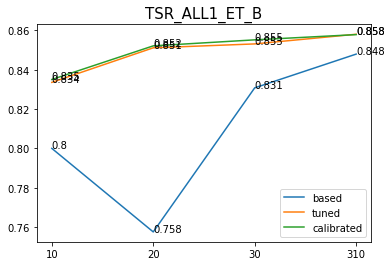

In [40]:
x = "10","20","30","310"
#plt.plot(x, B_train_auroc_list, label = "training")
plt.plot(x, B_test_auroc_list, label = "based")
#plt.plot(x, B_train_auroc_tuned_list, label = "training")
plt.plot(x, B_test_auroc_tuned_list, label = "tuned")
#plt.plot(x, B_train_auroc_cc_list, label = "training")
plt.plot(x, B_test_auroc_cc_list, label = "calibrated")
plt.legend()
for i in range(len(x)):
    plt.annotate(round(B_test_auroc_list[i],3), (x[i], B_test_auroc_list[i]))
    plt.annotate(round(B_test_auroc_tuned_list[i],3), (x[i], B_test_auroc_tuned_list[i]))
    plt.annotate(round(B_test_auroc_cc_list[i],3), (x[i], B_test_auroc_cc_list[i]))
plt.title('TSR_ALL1_ET_B', fontsize=15)
plt.savefig('INFO/TSR_ALL1/TSR_ALL1_ET_B.png')
plt.show()

## XGBClassifier

In [41]:
# base xgbc
xgbc = XGBClassifier(random_state=19, use_label_encoder=False, eval_metric = "auc", tree_method = "hist", n_jobs=-1)

# tune xgbc
hyperparameters_xgbc = {"xgbclassifier__booster": ("gbtree", "dart"),
                        "xgbclassifier__learning_rate": (0.01, 0.1),
                        "xgbclassifier__max_depth": (25, 50),
                        "xgbclassifier__subsample": (0.3, 0.8),
                        "xgbclassifier__colsample_bytree": (0.3, 0.8),
                        "xgbclassifier__reg_lambda": (0.1, 10),
                        "xgbclassifier__reg_alpha": (0.1, 10),
                        "xgbclassifier__gamma": (0.1, 10),
                        "xgbclassifier__n_estimators": (25, 100),
                        "xgbclassifier__scale_pos_weight": (0.25, 4)}

pipeline = make_pipeline(TomekLinks(), XGBClassifier(random_state=19, use_label_encoder=False, eval_metric="auc", tree_method = "hist"))

xgbcB_rscv = RandomizedSearchCV(estimator=pipeline,                       
                                param_distributions=hyperparameters_xgbc,                      
                                n_jobs=-1,                      
                                scoring="roc_auc",                     
                                verbose=5,                      
                                cv=5,                        
                                n_iter=50,
                                random_state = 19)

### BASE XGBC

In [42]:
xgbc.fit(B_X_train, B_y_train)

B_y_train_pred = xgbc.predict_proba(B_X_train)
fpr, tpr, thresholds = roc_curve(B_y_train , B_y_train_pred[:, 1])
B_train_auroc = auc(fpr, tpr)
print('AUC of training set:', B_train_auroc)

B_y_test_pred = xgbc.predict_proba(B_X_test)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc)

AUC of training set: 0.9996448602319168
AUC of testing set: 0.8515105958172051


C:\Users\Jacky C\anaconda3\envs\tsr_ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Jacky C\anaconda3\envs\tsr_ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


### TUNE XGBC

In [43]:
xgbcB_rsCV = xgbcB_rscv.fit(B_X_train, B_y_train)
print("--> Tuned Parameters Best Score: ", xgbcB_rsCV.best_score_)
print("--> Best Parameters: \n", xgbcB_rsCV.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
--> Tuned Parameters Best Score:  0.8625566526506242
--> Best Parameters: 
 {'xgbclassifier__subsample': 0.3, 'xgbclassifier__scale_pos_weight': 4, 'xgbclassifier__reg_lambda': 10, 'xgbclassifier__reg_alpha': 10, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__max_depth': 50, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__gamma': 10, 'xgbclassifier__colsample_bytree': 0.3, 'xgbclassifier__booster': 'gbtree'}


In [44]:
B_y_train_pred = xgbcB_rsCV.predict_proba(B_X_train)
fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
B_train_auroc_tuned = auc(fpr, tpr)
print('AUC of training set:', B_train_auroc_tuned)

B_y_test_pred = xgbcB_rsCV.predict_proba(B_X_test)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_tuned = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc_tuned)

AUC of training set: 0.8857174214452974
AUC of testing set: 0.8558422674555608


C:\Users\Jacky C\anaconda3\envs\tsr_ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Jacky C\anaconda3\envs\tsr_ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [45]:
xgbcB_cccv = CalibratedClassifierCV(base_estimator=xgbcB_rsCV.best_estimator_, cv=5)
xgbcB_ccCV = xgbcB_cccv.fit(B_X_train, B_y_train)

B_y_train_pred = xgbcB_ccCV.predict_proba(B_X_train)
fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
B_train_auroc_cc = auc(fpr, tpr)
print('AUC of training set:', B_train_auroc_cc)

B_y_test_pred = xgbcB_ccCV.predict_proba(B_X_test)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_cc = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc_cc)

C:\Users\Jacky C\anaconda3\envs\tsr_ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Jacky C\anaconda3\envs\tsr_ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


AUC of training set: 0.8838301157727799
AUC of testing set: 0.8555801349206205


## Thresholds

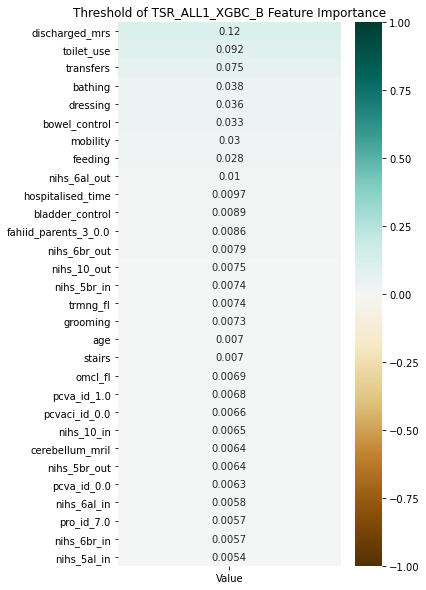

In [46]:
xgbcB_sigma = xgbcB_rsCV.best_estimator_._final_estimator.feature_importances_
xgbcB_sigma_df = pd.DataFrame(xgbcB_sigma)
xgbcB_sigma_df.index = B_x_train_columns
xgbcB_sigma_df.columns = (["Value"])
xgbcB_sigma_plot = xgbcB_sigma_df.sort_values(["Value"], ascending=False).head(30)
xgbcB_sigma_plot.index = (["Discharged mRS", "BI_toilet_use", "BI_transfers", "BI_bathing", "BI_dressing",
                           "BI_bowel_control", "BI_mobility", "BI_feeding", "Discharged NIHSS_6al",
                           "Inhospitalised duration", "BI_bladder_control", "Parents having ischemic stroke_0",
                           "Discharged NIHSS_6br", "Discharged NIHSS_10", "Admitted NIHSS_5br", 
                           "Inhospitalised treatment-nasogastric tube", "BI_grooming", "Age", "BI_stairs", 
                           "Clopidogrel after discharged", "Previous CVA_1", "Previous cerebral infraction_0", 
                           "Admitted NIHSS_10", "MRI_cerebellum_left", "Discharged NIHSS_5br", "Previous CVA_0",
                           "Admitted NIHSS_6al", "Profession_7", "Admitted NIHSS_6br", "Admitted NIHSS_5al"])

plt.figure(figsize=(5, 10))
sns.heatmap(xgbcB_sigma_plot, vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.title('Threshold of TSR_ALL1_XGBC_B Feature Importance')
plt.savefig('INFO/TSR_ALL1/xgbcB1_sigma_df.png')
plt.show()

### Selected Columns

In [47]:
xgbcB_sigma_df = xgbcB_sigma_df.reset_index(drop=False)
xgbcB_sigma_df.columns = (["Feature","Value"])
xgbcB_sigma_df = xgbcB_sigma_df.sort_values(["Value"], ascending=False)

B_train_auroc_list = []
B_test_auroc_list = []
B_train_auroc_tuned_list = []
B_test_auroc_tuned_list = []
B_train_auroc_cc_list = []
B_test_auroc_cc_list = []

for i in 10,20,30:
    xgbcB_sigma_index = xgbcB_sigma_df[0:i].index
    
    B_X_train = pd.DataFrame(B_X_train)
    B_X_train_selected = B_X_train.iloc[:, xgbcB_sigma_index]
    B_X_train_selected = np.array(B_X_train_selected.values)
    
    B_X_test = pd.DataFrame(B_X_test)
    B_X_test_selected = B_X_test.iloc[:, xgbcB_sigma_index]
    B_X_test_selected = np.array(B_X_test_selected.values)
    
    et = ExtraTreesClassifier(random_state=19)
    et.fit(B_X_train_selected, B_y_train)
    
    B_y_train_pred = et.predict_proba(B_X_train_selected)
    fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
    B_train_auroc_selected = auc(fpr, tpr)
    B_train_auroc_list.append(B_train_auroc_selected)
    
    B_y_test_pred = et.predict_proba(B_X_test_selected)
    fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
    B_test_auroc_selected = auc(fpr, tpr)
    B_test_auroc_list.append(B_test_auroc_selected)
    
    xgbcB_rsCV_selected = xgbcB_rscv.fit(B_X_train_selected, B_y_train)
    print('--> Tuned Paramxgbcers Best Score: ', xgbcB_rsCV_selected.best_score_)
    print('--> Best Paramxgbcers: \n', xgbcB_rsCV_selected.best_params_)

    B_y_train_pred = xgbcB_rsCV_selected.predict_proba(B_X_train_selected)
    fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
    B_train_auroc_selected_tuned = auc(fpr, tpr)
    B_train_auroc_tuned_list.append(B_train_auroc_selected_tuned)

    B_y_test_pred = xgbcB_rsCV_selected.predict_proba(B_X_test_selected)
    fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
    B_test_auroc_selected_tuned = auc(fpr, tpr)
    B_test_auroc_tuned_list.append(B_test_auroc_selected_tuned)

    xgbcB_cccv = CalibratedClassifierCV(base_estimator=xgbcB_rsCV_selected.best_estimator_, cv=5)
    xgbcB_ccCV = xgbcB_cccv.fit(B_X_train_selected, B_y_train)

    B_y_train_pred = xgbcB_ccCV.predict_proba(B_X_train_selected)
    fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
    B_train_auroc_selected_cc = auc(fpr, tpr)
    B_train_auroc_cc_list.append(B_train_auroc_selected_cc)

    B_y_test_pred = xgbcB_ccCV.predict_proba(B_X_test_selected)
    fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
    B_test_auroc_selected_cc = auc(fpr, tpr)
    B_test_auroc_cc_list.append(B_test_auroc_selected_cc)
    
B_train_auroc_list.append(B_train_auroc)
B_test_auroc_list.append(B_test_auroc)
B_train_auroc_tuned_list.append(B_train_auroc_tuned)
B_test_auroc_tuned_list.append(B_test_auroc_tuned)
B_train_auroc_cc_list.append(B_train_auroc_cc)
B_test_auroc_cc_list.append(B_test_auroc_cc)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
--> Tuned Paramxgbcers Best Score:  0.8458403061307092
--> Best Paramxgbcers: 
 {'xgbclassifier__subsample': 0.3, 'xgbclassifier__scale_pos_weight': 0.25, 'xgbclassifier__reg_lambda': 0.1, 'xgbclassifier__reg_alpha': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__max_depth': 25, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__gamma': 0.1, 'xgbclassifier__colsample_bytree': 0.3, 'xgbclassifier__booster': 'dart'}


C:\Users\Jacky C\anaconda3\envs\tsr_ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Jacky C\anaconda3\envs\tsr_ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Jacky C\anaconda3\envs\tsr_ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Jacky C\anaconda3\envs\tsr_ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Fitting 5 folds for each of 50 candidates, totalling 250 fits
--> Tuned Paramxgbcers Best Score:  0.8589652401303646
--> Best Paramxgbcers: 
 {'xgbclassifier__subsample': 0.3, 'xgbclassifier__scale_pos_weight': 4, 'xgbclassifier__reg_lambda': 0.1, 'xgbclassifier__reg_alpha': 10, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__max_depth': 50, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__gamma': 0.1, 'xgbclassifier__colsample_bytree': 0.3, 'xgbclassifier__booster': 'gbtree'}


C:\Users\Jacky C\anaconda3\envs\tsr_ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Jacky C\anaconda3\envs\tsr_ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Jacky C\anaconda3\envs\tsr_ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Jacky C\anaconda3\envs\tsr_ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Fitting 5 folds for each of 50 candidates, totalling 250 fits
--> Tuned Paramxgbcers Best Score:  0.8605064707557449
--> Best Paramxgbcers: 
 {'xgbclassifier__subsample': 0.8, 'xgbclassifier__scale_pos_weight': 0.25, 'xgbclassifier__reg_lambda': 10, 'xgbclassifier__reg_alpha': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__max_depth': 50, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__gamma': 0.1, 'xgbclassifier__colsample_bytree': 0.3, 'xgbclassifier__booster': 'dart'}


C:\Users\Jacky C\anaconda3\envs\tsr_ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Jacky C\anaconda3\envs\tsr_ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Jacky C\anaconda3\envs\tsr_ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Jacky C\anaconda3\envs\tsr_ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


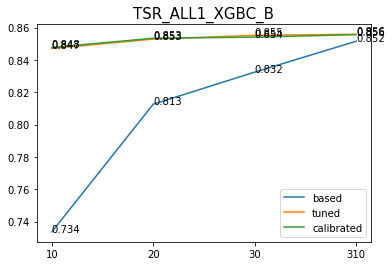

In [48]:
x = "10","20","30","310"
#plt.plot(x, B_train_auroc_list, label = "training")
plt.plot(x, B_test_auroc_list, label = "based")
#plt.plot(x, B_train_auroc_tuned_list, label = "training")
plt.plot(x, B_test_auroc_tuned_list, label = "tuned")
#plt.plot(x, B_train_auroc_cc_list, label = "training")
plt.plot(x, B_test_auroc_cc_list, label = "calibrated")
plt.legend()
for i in range(len(x)):
    plt.annotate(round(B_test_auroc_list[i],3), (x[i], B_test_auroc_list[i]))
    plt.annotate(round(B_test_auroc_tuned_list[i],3), (x[i], B_test_auroc_tuned_list[i]))
    plt.annotate(round(B_test_auroc_cc_list[i],3), (x[i], B_test_auroc_cc_list[i]))
plt.title('TSR_ALL1_XGBC_B', fontsize=15)
plt.savefig('INFO/TSR_ALL1/TSR_ALL1_XGBC_B.png')
plt.show()

In [50]:
a = pd.DataFrame(set(etG_sigma_plot.index) & set(xgbcG_sigma_plot.index) & set(etB_sigma_plot.index) & set(xgbcB_sigma_plot.index))
b = pd.DataFrame(set(etG_sigma_plot.index) | set(xgbcG_sigma_plot.index) | set(etB_sigma_plot.index) | set(xgbcB_sigma_plot.index))

c = pd.concat([a,b], axis = 1)
c[c.isnull()] = ""
c.columns = (["TSR1_AND", "TSR1_OR"])
csv_path = os.path.join("INFO", "TSR_ALL11.csv")
c.to_csv(csv_path)

In [51]:
a = pd.DataFrame(etG_sigma_plot.index)
b = pd.DataFrame(xgbcG_sigma_plot.index)
c = pd.DataFrame(etB_sigma_plot.index)
d = pd.DataFrame(xgbcB_sigma_plot.index)

e = pd.concat([a,b,c,d], axis = 1)
e.columns = (["TSR1_etG_sigma_plot", "TSR1_xgbcG_sigma_plot", "TSR1_etB_sigma_plot", "TSR1_xgbcB_sigma_plot"])
csv_path = os.path.join("INFO", "TSR_ALL1.csv")
e.to_csv(csv_path)